In [41]:
import gc
import importlib
import multiprocessing
from multiprocessing.pool import ThreadPool
import math
import os
import pathlib
import pickle
import random
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tqdm
import dask
import dask.multiprocessing


from tqdm import tqdm_notebook

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, train_test_split

import lightgbm as lgb
import xgboost as xgb

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, CuDNNGRU, Input, InputLayer
from keras.optimizers import adam
from keras.callbacks import ModelCheckpoint
from tensorflow import set_random_seed

In [2]:
importlib.reload(keras)

<module 'keras' from '/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/keras/__init__.py'>

In [3]:
keras.__version__

'2.2.4'

In [4]:
%matplotlib inline

In [5]:
dask.config.set(scheduler='processes')
dask.set_options( pool=ThreadPool(10) )

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/dask/context.py:23: UserWarning: The dask.set_options function has been deprecated. Please use dask.config.set instead
  warnings.warn("The dask.set_options function has been deprecated. "


In [6]:
def add_features_dask_parralel(
#def add_features_parallel(
        df,
        input_first_index=None,
        input_last_index=None,
        sample_size=150000,
        holdout_size=50000,
        smootch_windows_size = (3, 5, 7)
    ):
    if input_first_index == None or input_last_index == None:
        input_first_index = df.index.min()
        input_last_index = df.index.max() + 1
        
    
    sample_indexes = random.sample(range(input_first_index, input_last_index), sample_size)
    sample_indexes.sort()
    
    smootch_feature_names = ['smootch_mean_ws_{}'.format(window_size) for window_size in smootch_windows_size]
    acoustic_data_series = df['acoustic_data']
    full_data_indexes = tuple(acoustic_data_series.index.tolist())

    sample_df = df.iloc[sample_indexes]

    sample_df.reset_index(inplace=True)
    sample_df.drop(columns=['index'], inplace=True)

    output_first_index = 0
    output_last_index = len(sample_df) - 1
    
    begin_indexes_set = set()
    end_indexes_set = set()
    
    start_time = time.time()
   
    sample_df_len = sample_df.shape[0]
    @dask.delayed
    def create_features():
        for window_size, feature_name in zip(smootch_windows_size, smootch_feature_names):

            feature_values_list = list(range(sample_size))

            half_window_size = window_size // 2

            sample_begin_indexes = sample_indexes[:half_window_size]
            full_data_begin_indexes = set(df.index[sample_begin_indexes].tolist())
            min_full_data_index = min(full_data_indexes)
        
            in_window_full_data_begin_indexes = set(range(input_first_index, input_first_index + half_window_size))              
            in_window_begin_indexes = full_data_begin_indexes.intersection(
                in_window_full_data_begin_indexes
            )
        
            sample_end_indexes = sample_indexes[-half_window_size:]
            full_data_end_indexes = set(df.index[sample_end_indexes].tolist())
            max_full_data_index = max(full_data_end_indexes) + 1
        
            in_window_full_data_end_indexes = set(range(input_last_index - half_window_size, input_last_index))        
            in_window_end_indexes = full_data_end_indexes.intersection(
                in_window_full_data_end_indexes
            )
            if in_window_begin_indexes:
                begin_indexes_set = begin_indexes_set.union(in_window_begin_indexes)
                for i, b_idx in enumerate(sorted(tuple(in_window_begin_indexes))):
                    value = sample_df.iloc[i]['acoustic_data']
                    temp = acoustic_data_series.iloc[input_first_index:input_first_index + window_size].mean()
                    value = value - temp
                    feature_values_list[output_first_index + i] = value
                
            if in_window_end_indexes:
                end_indexes_set = end_indexes_set.union(in_window_end_indexes)
                for i, e_idx in enumerate(sorted(tuple(in_window_end_indexes))):
                    value = sample_df.iloc[output_last_index - i]['acoustic_data']
                    temp = acoustic_data_series.iloc[input_last_index - window_size:].mean()
                    value = value - temp
                    feature_values_list[output_last_index - i] = value
                
            first_regular_idx = len(begin_indexes_set)
            last_regular_idx = sample_df_len - len(end_indexes_set)
            for i in range(first_regular_idx, last_regular_idx):
                sample_idx = sample_indexes[i]
                feature_values_list[i] = acoustic_data_series.iloc[
                    sample_idx - half_window_size:sample_idx + half_window_size
                ].mean()
            sample_df[feature_name] = feature_values_list
        return sample_df
      
    sample_df = create_features().compute()
    holdout_df = None
    if holdout_size > 0:
        holdout_indexes = np.random.randint(0, sample_df.shape[0], holdout_size)
        holdout_df = sample_df.iloc[holdout_indexes]
        holdout_df.reset_index(inplace=True)
        holdout_df.drop(columns=['index'], inplace=True)
        train_indexes = sorted(tuple(set(sample_df.index).difference(set(holdout_indexes))))
        sample_df = sample_df.iloc[train_indexes]
        sample_df.reset_index(inplace=True)
        sample_df.drop(columns=['index'], inplace=True)
    print("Full calculation feature value time (with slicing) {} min:".format((time.time() - start_time) / 60))
    return sample_df, holdout_df

In [7]:
add_features = add_features_dask_parralel

In [8]:
def add_features(
        df,
        input_first_index=None,
        input_last_index=None,
        sample_size=150000,
        holdout_size=50000,
        smootch_windows_size = (3, 5, 7)
    ):
    if input_first_index == None or input_last_index == None:
        input_first_index = df.index.min()
        input_last_index = df.index.max() + 1
        
    
    sample_indexes = random.sample(range(input_first_index, input_last_index), sample_size)
    sample_indexes.sort()
    
    smootch_feature_names = ['smootch_mean_ws_{}'.format(window_size) for window_size in smootch_windows_size]
    acoustic_data_series = df['acoustic_data']
    full_data_indexes = tuple(acoustic_data_series.index.tolist())

    sample_df = df.iloc[sample_indexes]

    sample_df.reset_index(inplace=True)
    sample_df.drop(columns=['index'], inplace=True)

    output_first_index = 0
    output_last_index = len(sample_df) - 1
    
    begin_indexes_set = set()
    end_indexes_set = set()
    
    start_time = time.time()
   
    sample_df_len = sample_df.shape[0]
    for window_size, feature_name in zip(smootch_windows_size, smootch_feature_names):

        feature_values_list = list(range(sample_size))

        half_window_size = window_size // 2

        sample_begin_indexes = sample_indexes[:half_window_size]
        full_data_begin_indexes = set(df.index[sample_begin_indexes].tolist())
        min_full_data_index = min(full_data_indexes)
        
        in_window_full_data_begin_indexes = set(range(input_first_index, input_first_index + half_window_size))              
        in_window_begin_indexes = full_data_begin_indexes.intersection(
            in_window_full_data_begin_indexes
        )
        
        sample_end_indexes = sample_indexes[-half_window_size:]
        full_data_end_indexes = set(df.index[sample_end_indexes].tolist())
        max_full_data_index = max(full_data_end_indexes) + 1
        
        in_window_full_data_end_indexes = set(range(input_last_index - half_window_size, input_last_index))        
        in_window_end_indexes = full_data_end_indexes.intersection(
            in_window_full_data_end_indexes
        )
        if in_window_begin_indexes:
            begin_indexes_set = begin_indexes_set.union(in_window_begin_indexes)
            for i, b_idx in enumerate(sorted(tuple(in_window_begin_indexes))):
                value = sample_df.iloc[i]['acoustic_data']
                temp = acoustic_data_series.iloc[input_first_index:input_first_index + window_size].mean()
                value = value - temp
                feature_values_list[output_first_index + i] = value
                
        if in_window_end_indexes:
            end_indexes_set = end_indexes_set.union(in_window_end_indexes)
            for i, e_idx in enumerate(sorted(tuple(in_window_end_indexes))):
                value = sample_df.iloc[output_last_index - i]['acoustic_data']
                temp = acoustic_data_series.iloc[input_last_index - window_size:].mean()
                value = value - temp
                feature_values_list[output_last_index - i] = value
                
        first_regular_idx = len(begin_indexes_set)
        last_regular_idx = sample_df_len - len(end_indexes_set)
        for i in range(first_regular_idx, last_regular_idx):
            sample_idx = sample_indexes[i]
            feature_values_list[i] = acoustic_data_series.iloc[
                sample_idx - half_window_size:sample_idx + half_window_size
            ].mean()
        sample_df[feature_name] = feature_values_list
        
    holdout_df = None
    if holdout_size > 0:
        holdout_indexes = np.random.randint(0, sample_df.shape[0], holdout_size)
        holdout_df = sample_df.iloc[holdout_indexes]
        holdout_df.reset_index(inplace=True)
        holdout_df.drop(columns=['index'], inplace=True)
        train_indexes = sorted(tuple(set(sample_df.index).difference(set(holdout_indexes))))
        sample_df = sample_df.iloc[train_indexes]
        sample_df.reset_index(inplace=True)
        sample_df.drop(columns=['index'], inplace=True)
    print("Full calculation feature value time (with slicing) {} min:".format((time.time() - start_time) / 60))
    return sample_df, holdout_df

In [9]:
def extract_features(z):
    print()
    print("extract_features, z.shape:", z.shape)
    #print()
    return np.c_[z.mean(axis=1),
                 np.transpose(np.percentile(np.abs(z), q=[0, 50, 75, 100], axis=1)),
                 z.std(axis=1)]

def extract_features(z):
    return np.c_[z.mean(axis=1),
                 np.transpose(np.percentile(np.abs(z), q=[0, 50, 75, 100], axis=1)),
                 z.std(axis=1)]

In [10]:
def create_X(x, last_index=None, n_steps=150, step_length=1000):
    if last_index == None:
        last_index=len(x)
    
    print("\n")
    print("createX, x.shape:", x.shape)
    print("createX, last_index:", last_index)
    print("createX, n_steps:", n_steps)
    print("createX, step_length:", step_length)
    print("last_index - n_steps * step_length:", last_index - n_steps * step_length)
    assert last_index - n_steps * step_length >= 0

    # Reshaping and approximate standardization with mean 5 and std 3.
    # ORIGINAL: I changed this becuase I got an No OpKernel was registered to support Op 'CudnnRNN' error
    #temp = (x[(last_index - n_steps * step_length):last_index].reshape(n_steps, -1) - 5 ) / 3
    # MY CHANGE: This doesn't fix things, I get the same errors
    #temp = (x[(last_index - n_steps * step_length):last_index].reshape(n_steps, -1).astype(np.float32) - 5 ) / 3
    temp = x[(last_index - n_steps * step_length):last_index]
    print("createX, temp.shape before reshape:", temp.shape)
    temp = temp.reshape(n_steps, -1).astype(np.float32)
    print("create_X, temp.shape after reshape:", temp.shape)
    temp = (temp - 5) / 3
    
    # Extracts features of sequences of full length 1000, of the last 100 values and finally also 
    # of the last 10 observations.
    print("createX, extract_features(temp).shape:", extract_features(temp).shape)
    print("createX, extract_features(temp[:, -step_length // 10:]).shape", extract_features(temp[:, -step_length // 10:]).shape)
    print("createX, extract_features(temp[:, -step_length // 100:]).shape", extract_features(temp[:, -step_length // 100:]).shape)
    print()
    result = np.c_[
        extract_features(temp),
        extract_features(temp[:, -step_length // 10:]),
        extract_features(temp[:, -step_length // 100:])
    ]
    '''               
    result = np.c_[
        temp,
        temp[:, -step_length // 10:],
        temp[:, -step_length // 100:]
    ]
    '''
    print("createX, result shape:", result.shape)
    print()
    '''
    return np.c_[extract_features(temp),
                 extract_features(temp[:, -step_length // 10:]),
                 extract_features(temp[:, -step_length // 100:])]
    '''
    return result

def create_X(x, last_index=None, n_steps=150, step_length=1000):
    if last_index == None:
        last_index=len(x)
    
    assert last_index - n_steps * step_length >= 0

    # Reshaping and approximate standardization with mean 5 and std 3.
    # ORIGINAL: I changed this becuase I got an No OpKernel was registered to support Op 'CudnnRNN' error
    #temp = (x[(last_index - n_steps * step_length):last_index].reshape(n_steps, -1) - 5 ) / 3
    # MY CHANGE: This doesn't fix things, I get the same errors
    #temp = (x[(last_index - n_steps * step_length):last_index].reshape(n_steps, -1).astype(np.float32) - 5 ) / 3
    temp = x[(last_index - n_steps * step_length):last_index]

    temp = temp.reshape(n_steps, -1).astype(np.float32)

    temp = (temp - 5) / 3
    
    # Extracts features of sequences of full length 1000, of the last 100 values and finally also 
    # of the last 10 observations.

    result = np.c_[
        extract_features(temp),
        extract_features(temp[:, -step_length // 10:]),
        extract_features(temp[:, -step_length // 100:])
    ]

    return result

In [11]:
# The generator endlessly selects "batch_size" ending positions of sub-time series. For each ending position,
# the "time_to_failure" serves as target, while the features are created by the function "create_X".
#def generator(data, min_index=0, max_index=None, batch_size=16, n_steps=150, step_length=1000):
#def simplified_generator(data, y, batch_size=64, n_steps=150, step_length=1000):
def simplified_generator(data, y, batch_size=64):
    #if max_index is None:
    #    max_index = len(data) - 1
    print("\n")   
    print("generator, data.shape:", data.shape)
    print("generator, batch_size:", batch_size)
    num_of_features = data.shape[1]
    
    num_of_bathes = data.shape[0] // batch_size
    while True:
        for i in range(num_of_bathes):
        #chunk_len = batch_size * step_length
        
            data_chunk = data[i * batch_size:(i + 1) * batch_size].reshape(batch_size, 1, num_of_features)
            target_chunk = y[i * batch_size:(i + 1) * batch_size]
            yield data_chunk, target_chunk

In [12]:
def generator(data, y, batch_size=64):
    
    num_of_bathes = data.shape[0] // batch_size
    num_of_features = data.shape[1]
    
    #for i in range(num_of_bathes - 1):
    #i = 0
    
    shift = 0
    while True:
        
        #data_batch = data[i * batch_size:(i + 1) * batch_size].reshape(batch_size, 1, num_of_features)
        #target_batch = y[i * batch_size:(i + 1) * batch_size]
        #i += 1
        #yield data_batch, target_batch
        #samples = np.zeros((batch_size, n_steps, n_features))
        #targets = np.zeros(batch_size, )

        data_batch = np.zeros((batch_size, 1, num_of_features))
        target_batch = np.zeros(batch_size, )
        #data_batch = None
        #target_batch = None
        for i in range(shift, shift + batch_size):
            #print("i:", i)
            #samples[j] = create_X(data[:, 0], last_index=row, n_steps=n_steps, step_length=step_length)
            '''
            print("data_batch.shape:", data_batch.shape)
            print("data slice shape:", data[
                i * batch_size:(i + 1) * batch_size
            ].shape)
            print(
                "data_batch[i * batch_size:(i + 1) * batch_size].shape:",
                data_batch[i * batch_size:(i + 1) * batch_size].shape
            )
            
            data_batch[i * batch_size:(i + 1) * batch_size] = data[
                i * batch_size:(i + 1) * batch_size
            ].reshape(batch_size, 1, num_of_features)
            '''
            #data_batch = data[
            #    i * batch_size:(i + 1) * batch_size
            #].reshape(batch_size, 1, num_of_features)

            #target_batch[i * batch_size:(i + 1) * batch_size] = y[i * batch_size:(i + 1) * batch_size]
            #target_batch = y[i * batch_size:(i + 1) * batch_size]
            #targets[j] = data[row - 1, 1]
            data_batch[i] = data[i].reshape(1, 1, num_of_features)
            target_batch[i] = y[i]
            shift += batch_size
        #yield samples, targets
        yield data_batch, target_batch
#return None

def generator(data, y, batch_size=64):
    
    num_of_bathes = data.shape[0] // batch_size
    num_of_features = data.shape[1]
    
    while True:
        
        #data_batch = np.zeros((batch_size, 1, num_of_features))
        #target_batch = np.zeros(batch_size, )
        data_batch = None
        target_batch = None
        #for i in range(shift, shift + batch_size):
        for i in range(num_of_bathes):
            '''
            print("data_batch.shape:", data_batch.shape)
            print("data slice shape:", data[
                i * batch_size:(i + 1) * batch_size
            ].shape)
            print(
                "data_batch[i * batch_size:(i + 1) * batch_size].shape:",
                data_batch[i * batch_size:(i + 1) * batch_size].shape
            )
            
            data_batch[i * batch_size:(i + 1) * batch_size] = data[
                i * batch_size:(i + 1) * batch_size
            ].reshape(batch_size, 1, num_of_features)
            '''
            data_batch = data[
                i * batch_size:(i + 1) * batch_size
            ].reshape(batch_size, 1, num_of_features)

            #target_batch[i * batch_size:(i + 1) * batch_size] = y[i * batch_size:(i + 1) * batch_size]
            target_batch = y[i * batch_size:(i + 1) * batch_size]
            #data_batch[i] = data[i].reshape(1, 1, num_of_features)
            #target_batch[i] = y[i]
            #shift += batch_size
        #yield samples, targets
        yield data_batch, target_batch

def generator(data, y, rows, batch_size=16, n_steps=150, step_length=1000):
    #if max_index is None:
    #    max_index = len(data) - 1

        
    while True:
        
        # Pick indices of ending positions
        #rows = np.random.randint(min_index + n_steps * step_length, max_index, size=batch_size)
         
        # Initialize feature matrices and targets
        samples = np.zeros((batch_size, n_steps, n_features))
        targets = np.zeros(batch_size, )
        
        for j, row in enumerate(rows):
            samples[j] = create_X(data, last_index=row, n_steps=n_steps, step_length=step_length)
            #targets[j] = data[row - 1, 1]
            targets[j] = y[row - 1]
        yield samples, targets

In [13]:
generator = simplified_generator

In [34]:
n_features = 3

In [35]:
cb = [ModelCheckpoint("model.hdf5", save_best_only=True, period=3)]

model = Sequential()
model.add(CuDNNGRU(48, input_shape=(None, n_features)))
#model.add(InputLayer((4096, 4)))
#model.add(Dense(48))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, input_dim=1000))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_2 (CuDNNGRU)       (None, 48)                7632      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                490       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 8,133
Trainable params: 8,133
Non-trainable params: 0
_________________________________________________________________


In [16]:
#float_data = pd.read_csv("../input/train/train.csv", dtype={"acoustic_data": np.float32, "time_to_failure": np.float32}).values

In [17]:
%%time
#        earthquake_df = pd.read_csv(
#                '../input/train/train.csv',
#                #nrows=100000000,
#                names=['acoustic_data', 'time_to_failure'],
#                dtype={'acoustic_data': np.float32, 'time_to_failure': np.float32},
#                skiprows=earthquake_margin_indexes[i],
#                nrows=complete_earthquakes_length[i]
#            )

train_df = pd.read_csv('../input/train/train.csv', dtype={'acoustic_data': np.float32, 'time_to_failure': np.float32})

CPU times: user 2min 24s, sys: 9.72 s, total: 2min 34s
Wall time: 2min 33s


In [18]:
%%time
#        if not sample_size:
#            sample_size = complete_earthquakes_length[i] // 10
#        if not holdout_size:
#            holdout_size = complete_earthquakes_length[i] // 50
#sample_size = train_df.shape[0] // 10
#holdout_size = train_df.shape[0] // 50
sample_size = 15000000
holdout_size = 3000000
featured_train_df, featured_holdout_df = add_features(
                train_df,
                sample_size=sample_size,
                holdout_size=holdout_size,
                smootch_windows_size = (7, 9)
            )

Full calculation feature value time (with slicing) 115.58776901563009 min:
CPU times: user 1h 56min 45s, sys: 40.3 s, total: 1h 57min 25s
Wall time: 1h 57min 20s


In [19]:
featured_train_df.head()

,acoustic_data,time_to_failure,smootch_mean_ws_7,smootch_mean_ws_9
0,3.0,1.4691,6.000000,6.125
1,7.0,1.4691,6.000000,5.875
2,6.0,1.4691,5.333333,5.125
3,10.0,1.4691,7.000000,6.750
4,8.0,1.4691,5.333333,5.250


In [20]:
X_all = featured_train_df[featured_train_df.columns.drop('time_to_failure')]
y_all = featured_train_df['time_to_failure']

In [21]:
#X_all.kurtosis?

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(X_all, y_all, test_size=0.2, random_state=0)

In [23]:
#X_train.shape[0] // 512

X_train = X_train[:9592 * 512]
y_train = y_train[:9592 * 512]
X_valid = X_valid[:2397 * 512]
y_valid = y_valid[:2397 * 512]

X_temp.shape[0] % 512

X_valid.shape[0] // 512

train_rows = tuple(range(0, 4800000, 150000))[1:]
valid_rows = tuple(range(0, 1200000, 150000))[1:]
print(train_rows)
print(valid_rows)

In [24]:
# Query "create_X" to figure out the number of features
#n_features = create_X(float_data[0:150000]).shape[1]
#n_features = create_X(X_train[0:150000].values).shape[1]
#print("Our RNN is based on %i features"% n_features)

In [36]:
batch_size = 512

# Position of second (of 16) earthquake. Used to have a clean split
# between train and validation
#second_earthquake = 50085877
#float_data[second_earthquake, 1]
#X_train[second_earthquake, 1]

# Initialize generators
# train_gen = generator(float_data, batch_size=batch_size) # Use this for better score
# train_gen = generator(float_data, batch_size=batch_size, min_index=second_earthquake + 1)
# valid_gen = generator(float_data, batch_size=batch_size, max_index=second_earthquake)
train_gen = generator(X_train.values, y_train.values, batch_size=batch_size)
valid_gen = generator(X_valid.values, y_valid.values, batch_size=batch_size)

In [31]:
data, target = train_gen.__next__()

In [32]:
print(data.shape)
print(target.shape)

(512, 1, 3)
(512,)


In [29]:
keras.__version__

'2.2.4'

in_ = Input(shape = (4096, 4), name='input_1')
out = Dense(48, activation='relu', name='dense_1')(in_)

model = Model(in_, out)
#model.add(Dense(48), name='dense_2')
#model.add(Dense(10, activation='relu', name='dense_2'))
#model.add(Dense(1, name='dense_3'))

model.summary()

In [37]:
model.compile(optimizer=adam(lr=0.0005), loss="mae")

history = model.fit_generator(train_gen,
                              steps_per_epoch=1000,
                              epochs=30,
                              verbose=1,
                              callbacks=cb,
                              validation_data=valid_gen,
                              validation_steps=200)

Epoch 1/30


generator, data.shape: (2456159, 3)
generator, batch_size: 512


generator, data.shape: (9824636, 3)
generator, batch_size: 512
1000/1000 [==============================] - 8s 8ms/step - loss: 3.2135 - val_loss: 3.0102
Epoch 2/30
1000/1000 [==============================] - 5s 5ms/step - loss: 3.0032 - val_loss: 2.9946
Epoch 3/30
1000/1000 [==============================] - 5s 5ms/step - loss: 2.9990 - val_loss: 2.9937
Epoch 4/30
1000/1000 [==============================] - 5s 5ms/step - loss: 2.9957 - val_loss: 2.9994
Epoch 5/30
1000/1000 [==============================] - 5s 5ms/step - loss: 2.9956 - val_loss: 2.9991
Epoch 6/30
1000/1000 [==============================] - 5s 5ms/step - loss: 2.9972 - val_loss: 2.9940
Epoch 7/30
1000/1000 [==============================] - 5s 5ms/step - loss: 2.9977 - val_loss: 2.9973
Epoch 8/30
1000/1000 [==============================] - 5s 5ms/step - loss: 2.9984 - val_loss: 2.9943
Epoch 9/30
1000/1000 [==============================] 

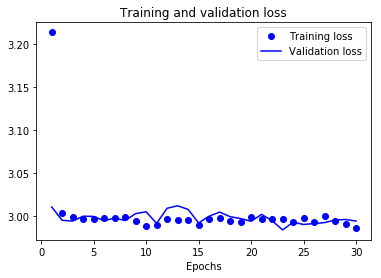

In [38]:
def perf_plot(history, what = 'loss'):
    x = history.history[what]
    val_x = history.history['val_' + what]
    epochs = np.asarray(history.epoch) + 1
    
    plt.plot(epochs, x, 'bo', label = "Training " + what)
    plt.plot(epochs, val_x, 'b', label = "Validation " + what)
    plt.title("Training and validation " + what)
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    return None

perf_plot(history)

In [39]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})

In [43]:
for i, seg_id in enumerate(tqdm.tqdm_notebook(submission.index)):
  #  print(i)
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    x = seg['acoustic_data'].values
    submission.time_to_failure[i] = model.predict(np.expand_dims(create_X(x), 0))

submission.head()



createX, x.shape: (150000,)
createX, last_index: 150000
createX, n_steps: 150
createX, step_length: 1000
last_index - n_steps * step_length: 0
createX, temp.shape before reshape: (150000,)
create_X, temp.shape after reshape: (150, 1000)

extract_features, z.shape: (150, 1000)
createX, extract_features(temp).shape: (150, 6)

extract_features, z.shape: (150, 100)
createX, extract_features(temp[:, -step_length // 10:]).shape (150, 6)

extract_features, z.shape: (150, 10)
createX, extract_features(temp[:, -step_length // 100:]).shape (150, 6)


extract_features, z.shape: (150, 1000)

extract_features, z.shape: (150, 100)

extract_features, z.shape: (150, 10)
createX, result shape: (150, 18)




ValueError: Error when checking input: expected cu_dnngru_2_input to have shape (None, 3) but got array with shape (150, 18)

In [ ]:
submission.to_csv('submission.csv')